In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
from copy import deepcopy
import bayesian_torch
import torchcontrib

import sys
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/paper")
from src.optimizers.entropy_sgd import EntropySGD
from laplace import Laplace
from torch.utils.data import TensorDataset
from tqdm import tqdm

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (5, 3)
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Computer Modern'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

# Marquis de Laplace's color 
c1 = (38/255, 81/255, 206/255)
c2 = (232/255, 220/255, 87/255)
c3 = (238/255, 238/255, 238/255)
c4 = (0, 0, 0)
# some plotting options
A4_width = 8.27
A4_height = 11.69
# just one column 
textwidth = 5.50107

/opt/homebrew/Caskroom/miniforge/base/envs/Lightning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Predictive

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


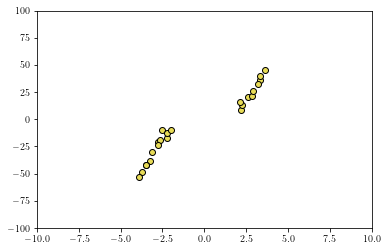

In [2]:
np.random.seed(9999)

# Toy problem from PBP paper (Lobato-Hernandez & Adams, 2015)
train_size = 50
data_noise = 3

X = np.random.uniform(-4, 4, size=(train_size, 1))
X = np.array([x for x in X if x < -2 or x > 2])
y = X**3 + np.random.randn(*X.shape)*data_noise  # Noise is N(0, 3^2)

plt.scatter(X.flatten(), y.flatten(), c=c2, edgecolor=c4);
plt.xlim(-10, 10);
plt.ylim(-100, 100);

In [3]:
from torch.nn.utils import parameters_to_vector
from backpack import extend, backpack
from backpack.extensions import DiagGGNExact


torch.manual_seed(7777)

m, n = X.shape
h = 20  # num. hidden units per layer
k = 1  # num. of output unit
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()


In [4]:
def train_model(tau, init_model):
    model = deepcopy(init_model)
    loss_fun = nn.MSELoss()
    extend(model)
    extend(loss_fun)
    weight_decay = 5e-4
    opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=weight_decay)

    sgd_trajectories = [parameters_to_vector(model.parameters()).detach().numpy()]

    for it in range(2001):
        with backpack(DiagGGNExact()):
            y_pred = model(X_train)
            l = loss_fun(y_pred, y_train)
            l.backward(create_graph=True)
        log_det_loss = 0
        if tau > 0:
            for name, param in model.named_parameters():
                    log_det_loss += param.diag_ggn_exact.log().mean()
            (tau * log_det_loss/X_train.shape[0]).backward()
        opt.step()
        opt.zero_grad()
        
        if it % 1 == 0:
            sgd_trajectories.append(parameters_to_vector(model.parameters()).detach().numpy())
            
    sgd_trajectories = np.array(sgd_trajectories)
    print(f'Loss: {l.item():.3f}')
    return sgd_trajectories, model

In [5]:
init_model = nn.Sequential(nn.Linear(n,h), nn.Tanh(), nn.Linear(h, 1))
sgd_01, model_01 = train_model(4, init_model)
sgd_trajectories, model = train_model(0, init_model)

/opt/homebrew/Caskroom/miniforge/base/envs/Lightning/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1658221001171/work/torch/csrc/autograd/engine.cpp:1000.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss: 5.630
Loss: 5.626


In [6]:
def train_swa(tau, init_model):
    model = deepcopy(init_model)
    loss_fun = nn.MSELoss()
    extend(model)
    extend(loss_fun)
    weight_decay = 5e-4
    opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=weight_decay)
    swa_opt = torchcontrib.optim.SWA(opt, swa_start=1500, swa_freq=10, swa_lr=1e-2)
    swa_opt.param_groups = swa_opt.optimizer.param_groups
    swa_opt.state = swa_opt.optimizer.state
    swa_opt.defaults=swa_opt.optimizer.defaults

    sgd_trajectories = [parameters_to_vector(model.parameters()).detach().numpy()]

    for it in range(2001):
        y_pred = model(X_train)
        l = loss_fun(y_pred, y_train)
        l.backward()
        swa_opt.step()
        swa_opt.zero_grad()
        
        if it % 1 == 0:
            sgd_trajectories.append(parameters_to_vector(model.parameters()).detach().numpy())
            
    sgd_trajectories = np.array(sgd_trajectories)
    swa_opt.swap_swa_sgd()
    sgd_trajectories[-1] = parameters_to_vector(model.parameters()).detach().numpy()

    print(f'Loss: {l.item():.3f}')
    return sgd_trajectories, model

In [7]:
swa_traj, swa_model = train_swa(0, init_model)

Loss: 10.823


In [8]:
def train_entropy(tau, init_model):
    model = deepcopy(init_model)
    loss_fun = nn.MSELoss()
    extend(model)
    extend(loss_fun)
    weight_decay = 5e-4
    config = {"lr": 1e-3, "momentum":0.9, "weight_decay":weight_decay, "L":5, "g0":1e-1, "g1":0, "noise":1e-4, "nesterov":False}
    opt = EntropySGD(model.parameters(),config=config)
    sgd_trajectories = [parameters_to_vector(model.parameters()).detach().numpy()]

    def closure():
        loss = loss_fun(model(X_train), y_train)
        loss.backward()
        return loss, None
    for it in range(2001):
        l,_ = opt.step(closure=closure, model=model, criterion=nn.MSELoss())
        
        if it % 1 == 0:
            sgd_trajectories.append(parameters_to_vector(model.parameters()).detach().numpy())
            
    sgd_trajectories = np.array(sgd_trajectories)

    print(f'Loss: {l.item():.3f}')
    return sgd_trajectories, model
ent_traj, ent_model = train_entropy(0, init_model=init_model)

/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/paper/src/optimizers/entropy_sgd.py:69: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1658221001171/work/torch/csrc/utils/python_arg_parser.cpp:1174.)
  dw.add_(wd, w.data)


Loss: 178.157


In [9]:
ent_traj

array([[ 0.4906242 ,  0.46557808, -0.53003967, ..., -0.18361571,
        -0.14194942, -0.09546643],
       [ 0.340647  ,  0.48149025, -0.05251978, ..., -0.06134549,
        -0.10769724, -0.10632835],
       [ 0.11915686,  0.5113759 ,  0.66163707, ...,  0.10246632,
        -0.06196085, -0.12621015],
       ...,
       [13.674656  ,  4.358286  , 10.790773  , ...,  1.2074934 ,
        -0.14814869, -1.1655728 ],
       [13.674258  ,  4.35817   , 10.790459  , ...,  1.2074368 ,
        -0.14816673, -1.1654783 ],
       [13.673861  ,  4.358053  , 10.790144  , ...,  1.2073779 ,
        -0.14818695, -1.1653918 ]], dtype=float32)

In [10]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from copy import deepcopy

In [11]:
1/sqrt(2* 5e-4 * X_train.shape[0])

6.593804733957869

In [12]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": -1, #1/sqrt(2* 5e-4 * X_train.shape[0]),#1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 1,
}

def params_to_save(model):
        params = []
        for name, param in model.named_parameters():
                if "mu" in name:
                        params.append(param)
        return parameters_to_vector(params)
    
bnn_model = deepcopy(init_model)
dnn_to_bnn(bnn_model, const_bnn_prior_parameters)
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(bnn_model.parameters(), lr=1e-3, momentum=0.9)
bnn_trajectory = []
for i in range(2001):
        bnn_trajectory.append(params_to_save(bnn_model).detach().clone())
        optimizer.zero_grad()
        output = bnn_model(X_train)
        kl = get_kl_loss(bnn_model)
        ce_loss = criterion(output, y_train)
        loss = ce_loss +  kl / X_train.shape[0] * 20
        loss.backward()
        optimizer.step()
bnn_trajectory = torch.vstack(bnn_trajectory)

In [13]:
def plot(X_test, mean, std=None, fname=None):
    plt.plot(X_test, mean, c=c4, lw=3);
    plt.plot(X_test, mean, c=c4, lw=2);
    
    if std is not None:
        plt.fill_between(X_test.flatten(), mean-1.96*std, mean+1.96*std, color=c1, alpha=0.3);

    plt.scatter(X.flatten(), y.flatten(), marker='X', s=50, c='white', edgecolors='black', lw=1, zorder=100);
    plt.xlim(-8, 8); plt.xticks([]);
    plt.ylim(-100, 100); plt.yticks([]);
    
    if fname is not None:
        plt.savefig(f'figs/{fname}.pdf', bbox_inches='tight')
        
    plt.show();

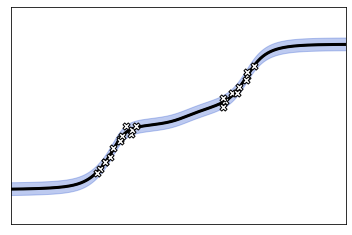

In [14]:
X_test_np = np.linspace(-10, 10, 1000).reshape(-1, 1)
X_test = torch.from_numpy(X_test_np).float()

y_pred = model(X_test).squeeze().detach().numpy()

plot(X_test_np, y_pred, std=3*np.ones_like(y_pred))

### Laplace

In [15]:
def fit_la(model, train_set):
    model_for_la = deepcopy(init_model)
    model_for_la.load_state_dict(model.state_dict())
    model_la = Laplace(model=model_for_la, likelihood="regression", subset_of_weights="all", hessian_structure="kron")
    model_la.fit(train_set)
    log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
    hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
    for i in tqdm(range(100)):
        hyper_optimizer.zero_grad()
        neg_marglik = - model_la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
        neg_marglik.backward()
        hyper_optimizer.step()
    return model_la

@torch.no_grad()
def plot_predictions(model, prob=True):
    if prob:
        mean, var = model(X_test)
        std = torch.sqrt(torch.flatten(var) + model.sigma_noise.item()**2)
        mean = mean.flatten()
    else:
        mean = model(X_test).flatten()
        std = np.ones_like(mean)
    plt.plot(X_test, mean, c=c4, lw=3);
    plt.plot(X_test, mean, c=c4, lw=2);
    
    if std is not None:
        plt.fill_between(X_test.flatten(), mean-1.96*std, mean+1.96*std, color=c1, alpha=0.3);

    plt.scatter(X.flatten(), y.flatten(), marker='X', s=50, c='white', edgecolors='black', lw=1, zorder=100);
    plt.xlim(-8, 8); plt.xticks([]);
    plt.ylim(-100, 100); plt.yticks([]);        
    plt.show();


100%|██████████| 100/100 [00:00<00:00, 1615.66it/s]


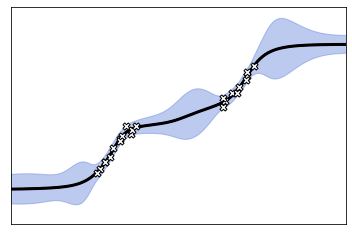

100%|██████████| 100/100 [00:00<00:00, 2035.38it/s]


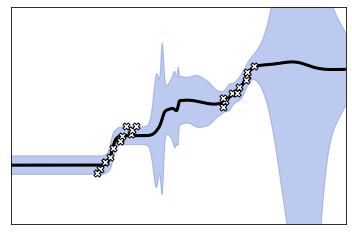

100%|██████████| 100/100 [00:00<00:00, 1780.28it/s]


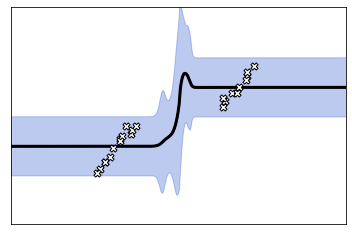

100%|██████████| 100/100 [00:00<00:00, 780.21it/s]


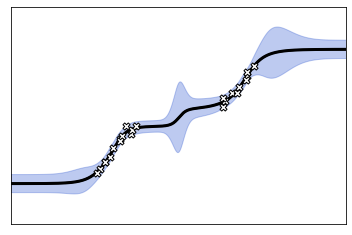

In [16]:
dataloader = TensorDataset(X_train.unsqueeze(dim=0), y_train.unsqueeze(dim=0))
dataloader.dataset = X_train
map_model_la = fit_la(model, dataloader)
plot_predictions(map_model_la)
map_model_la = fit_la(swa_model, dataloader)
plot_predictions(map_model_la)
map_model_la = fit_la(ent_model, dataloader)
plot_predictions(map_model_la)
map_model_la = fit_la(model_01, dataloader)
plot_predictions(map_model_la)

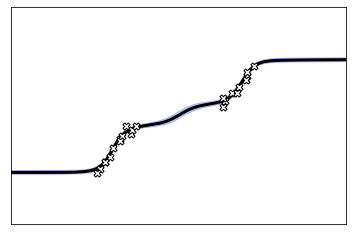

In [17]:
sample_preds = []
with torch.no_grad():
    for i in range(1000):
        sample_preds.append(bnn_model(X_test))
sample_preds = torch.stack(sample_preds).flatten(-2)
pred_mean = sample_preds.mean(dim=0)
pred_std = sample_preds.std(dim=0)
# print(pred_std)
plt.plot(X_test, pred_mean, c=c4, lw=3);
plt.plot(X_test, pred_mean, c=c4, lw=2);

plt.fill_between(X_test.flatten(), pred_mean-1.96*pred_std, pred_mean+1.96*pred_std, color=c1, alpha=0.3);

plt.scatter(X.flatten(), y.flatten(), marker='X', s=50, c='white', edgecolors='black', lw=1, zorder=100);
plt.xlim(-8, 8); plt.xticks([]);
plt.ylim(-100, 100); plt.yticks([]);        
plt.show();

# SGD

(2002, 61)
[[17.971561   4.812416 ]
 [17.869886   4.6864514]
 [17.680151   4.4479413]
 [17.417355   4.110634 ]]
[[17.97155878  4.81241584]
 [17.93206976  4.74533709]
 [17.82204794  4.60342888]
 [17.65018927  4.41879889]]


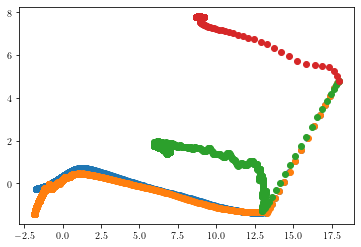

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


print(sgd_trajectories.shape)

# PCA projection of parameters 
pca = PCA(n_components=2).fit(sgd_trajectories)
sgd_traj_proj = pca.transform(sgd_trajectories)
sgd_01_traj_proj = pca.transform(sgd_01)
bnn_tarj_proj = pca.transform(bnn_trajectory)
swa_traj_proj = pca.transform(swa_traj)
ent_traj_proj = pca.transform(ent_traj)

print(sgd_traj_proj[:4])
print(bnn_tarj_proj[:4])

plt.scatter(sgd_traj_proj[:, 0], sgd_traj_proj[:, 1])
plt.scatter(sgd_01_traj_proj[:, 0], sgd_01_traj_proj[:, 1])
plt.scatter(bnn_tarj_proj[:, 0], bnn_tarj_proj[:, 1])
plt.scatter(ent_traj_proj[:, 0], ent_traj_proj[:, 1])
# plt.scatter(swa_traj_proj[:, 0], swa_traj_proj[:, 1])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

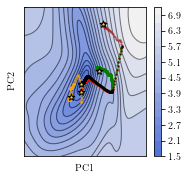

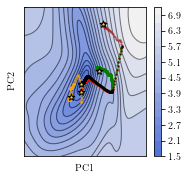

In [19]:
from backpack.utils.convert_parameters import vector_to_parameter_list
from matplotlib.colors import ListedColormap


def plot_loss_landscape(X_train, y_train, return_thetas=False):
    # In PCA space
    grid_size = 100
    # range_x = np.linspace(-50, 50, grid_size)
    # range_y = np.linspace(-30, 30, grid_size)
    range_y = np.linspace(-10, 10, grid_size)
    range_x = np.linspace(-30, 30, grid_size)
    w1s, w2s = np.meshgrid(range_x, range_y)
    thetas_latent = np.stack([w1s.ravel(), w2s.ravel()]).T
    
    # Project back to the parameter space
    thetas = pca.inverse_transform(thetas_latent)
    thetas = torch.from_numpy(thetas).float()
    
    losses = []
    ggns = []
    n_params = parameters_to_vector(nn.Sequential(nn.Linear(n,h), nn.Tanh(), nn.Linear(h, 1)).parameters()).shape[0]
    
    for theta in thetas:
        _model = nn.Sequential(nn.Linear(n,h), nn.Tanh(), nn.Linear(h, 1))
        _loss_fun = nn.MSELoss()
        extend(_model)
        extend(_loss_fun)
        # vector_to_parameter_list(theta, _model.parameters())
        for new_p, model_p in zip(vector_to_parameter_list(theta, _model.parameters()), _model.parameters()):
            model_p.data = new_p.data

        with backpack(DiagGGNExact()):
            loss = _loss_fun(_model(X_train), y_train) + 5e-4 * parameters_to_vector(_model.parameters()).square().sum()
            loss.backward()
            log_det_loss = 0
            for name, param in _model.named_parameters():
                log_det_loss += param.diag_ggn_exact.log().sum()
            ggns.append(log_det_loss.detach().clone()/n_params)


        # for p in _model.parameters():
        #     loss += weight_decay/2 * torch.norm(p, 2)
        
        losses.append(loss.item())
    
    ggns = np.array(ggns)
    # print(ggns.min(), ggns.max())
    # print(np.isnan(np.mean(ggns)))
    losses = np.array(losses)
    # losses = np.minimum(2700, losses)
    losses = np.log(losses)
    
    # Marquis de Laplace's colormap
    N = 25
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(c1[0], c3[0], N)
    vals[:, 1] = np.linspace(c1[1], c3[1], N)
    vals[:, 2] = np.linspace(c1[2], c3[2], N)
    cmap = ListedColormap(vals)
    
    # fig, (ax, ax2) = plt.subplots(1, 2, figsize=(25,10))
    # l = ax.contourf(
    #     w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
    #     cmap=cmap, alpha=0.8, 
    # )
    # l2 = ax2.contourf(
    #     w1s, w2s, ggns.reshape(grid_size, grid_size), levels=20, 
    #     cmap=cmap, alpha=0.8, 
    # )
    # ax.contour(
    #     w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
    #     alpha=0.5, colors='k'
    # )
    # fig.colorbar(l, ax=ax)
    # fig.colorbar(l2, ax=ax2)

    # return (fig, ax, w1s, w2s, thetas_latent) if return_thetas else (fig, ax, ax2)
    
    # plt.xticks([])
    # plt.yticks([])
    fig, ax = plt.subplots(1, figsize=(0.5 * textwidth, 0.5 * textwidth))
    l = ax.contourf(
        w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
        cmap=cmap, alpha=0.8, 
    )
    ax.contour(
        w1s, w2s, losses.reshape(grid_size, grid_size), levels=20, 
        alpha=0.5, colors='k'
    )
    fig.colorbar(l, ax=ax)
    
    plt.xticks([])
    plt.yticks([])
    
    return (fig, ax, w1s, w2s, thetas_latent) if return_thetas else (fig, ax)

def plot_trajectory(traj, ax, col=c3, label=None):
    ax.scatter(traj[:, 0], traj[:, 1], c=col, edgecolors=c4, lw=0, alpha=0.8, zorder=9, label=label, s=5)
    ax.scatter(traj[-1:, 0], traj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=50, lw=1, zorder=10)
    
fig, ax = plot_loss_landscape(X_train, y_train)
plot_trajectory(sgd_01_traj_proj, ax, col="red", label="VL")
plot_trajectory(bnn_tarj_proj, ax, col="green", label="VB")
plot_trajectory(swa_traj_proj, ax, col="orange", label="SWA")
plot_trajectory(ent_traj_proj, ax, col="brown", label="ENT")
plot_trajectory(sgd_traj_proj, ax, col="black", label="MAP")
# ax.scatter(sgd_traj_proj[:, 0], sgd_traj_proj[:, 1], c=c3, edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax.scatter(sgd_traj_proj[-1:, 0], sgd_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)
# ax.scatter(sgd_01_traj_proj[:, 0], sgd_01_traj_proj[:, 1], c="red", edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax.scatter(sgd_01_traj_proj[-1:, 0], sgd_01_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)

# ax2.scatter(sgd_traj_proj[:, 0], sgd_traj_proj[:, 1], c=c3, edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax2.scatter(sgd_traj_proj[-1:, 0], sgd_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)
# ax2.scatter(sgd_01_traj_proj[:, 0], sgd_01_traj_proj[:, 1], c="red", edgecolors=c4, lw=0, alpha=1, zorder=9)
# ax2.scatter(sgd_01_traj_proj[-1:, 0], sgd_01_traj_proj[-1:, 1], c=c2, marker='*', edgecolors=c4, s=200, lw=1.5, zorder=10)

# plot_trajectory(sgd_traj_proj, ax2, col="black")
# plot_trajectory(sgd_01_traj_proj, ax2, col="red")
# plot_trajectory(bnn_tarj_proj, ax2, col="green")

# ax.set_title("Loss landscape (log of MSE)", fontsize=25)
# ax.legend()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
# ax2.set_title("negative Entropy landscape", fontsize=25)
fig
# fig.savefig("Comparison_VI.jpg")

In [20]:
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.4, -0.2), ncol=2, handletextpad=0.2, labelspacing=0.2, columnspacing=1)

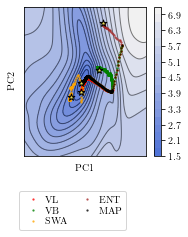

In [21]:
fig

In [22]:
fig.tight_layout()
# fig.savefig("Final_Comparison.pdf",  bbox_extra_artists=(lgd,))